# Collecting Data from Visible and Thermal Cameras from Plants

In [1]:
import sys
sys.path.append('..')

In [2]:
import time
import datetime
import threading
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from IPython import display

from skimage.exposure import rescale_intensity, equalize_adapthist

from cameras.wrapper_boson import BosonWithTelemetry
from cameras.wrapper_pyspin import Blackfly
from lights.light_intensity_controller import LightIntensityController
from thorlabs_elliptec import ELLx

In [3]:
COMPUTE_CORRECTION_TERM = False

# Initialize Hardware

In [4]:
USE_STAGE = True
STAGE_POS_BP680 = 0
STAGE_POS_LP700 = 31
STAGE_POS_SP700 = 62
STAGE_POS_CLEAR = 93

In [5]:
vis_cam_obj = Blackfly()
vis_cam_obj.set_fps(50)
vis_cam_obj.set_gain(0)
vis_cam_obj.set_exposure(1000)

System Time: 1733272950.2551303 s...
Timestamp Latch Value: 4862327029000 ns...
Current FPS: 49.988163...
Exposure set to 3999.000000 us...
Gain set to 0.000000 dB...
Exposure set to 1000.000000 us...


1000.0

In [6]:
thr_cam_obj = BosonWithTelemetry()

In [7]:
if USE_STAGE:
    curr_stage_pos = STAGE_POS_LP700
    stage = ELLx()
    stage.move_absolute_raw(curr_stage_pos)

In [8]:
light_obj = LightIntensityController()
light_obj.set_voltage(0.0)

## Preview Visible Camera

In [9]:
high_voltage = 10
curr_stage_pos = STAGE_POS_LP700
curr_exposure = 750
stage.move_absolute_raw(curr_stage_pos)
vis_cam_obj.set_exposure(curr_exposure)
vis_cam_obj.set_gain(0)

Exposure set to 748.000000 us...
Gain set to 0.000000 dB...


0.0

In [14]:
## Collect an image with light at 0
light_obj.set_voltage(0.0)
for _ in tqdm(range(10)):
    vis_cam_obj.get_next_image()
vis_cam_img1 = vis_cam_obj.get_next_image()[0].astype(np.float32)

## Change the light intensity to 1.0
light_obj.set_voltage(high_voltage)
for _ in tqdm(range(10)):
    vis_cam_obj.get_next_image()
vis_cam_img2 = vis_cam_obj.get_next_image()[0].astype(np.float32)

## Change the light intensity to 0.0
light_obj.set_voltage(0.0)

100%|██████████| 10/10 [00:00<00:00, 50.64it/s]


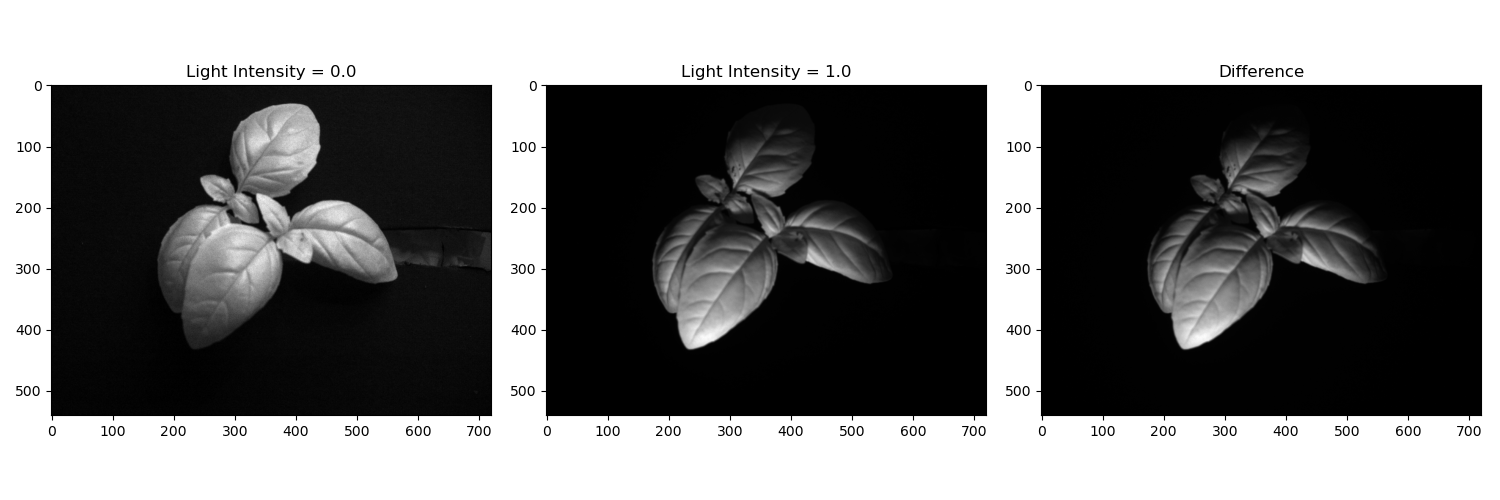

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(vis_cam_img1, cmap='gray')
ax[0].set_title('Light Intensity = 0.0')

ax[1].imshow(vis_cam_img2, cmap='gray')
ax[1].set_title('Light Intensity = 1.0')

ax[2].imshow(vis_cam_img2 - vis_cam_img1, cmap='gray')
ax[2].set_title('Difference')

plt.tight_layout()
plt.show()
save_image_filename = f'light_intensity_test_v{high_voltage}_e{curr_exposure}_f{curr_stage_pos}.png'
fig.savefig(save_image_filename)


## Preview Thermal Camera

In [9]:
def preview_thermal_frame(frame_raw: np.ndarray, in_range='image', equalize=False, apply_colormap=True) -> np.ndarray:
    frame = rescale_intensity(frame_raw.astype(float), in_range=in_range, out_range=(0, 1.0))
    if equalize:
        frame = np.uint8(equalize_adapthist(frame) * 255)
    else:
        frame = np.uint8(frame * 255)
    if apply_colormap:
        frame = cv2.applyColorMap(frame, cv2.COLORMAP_TURBO)[..., ::-1]
    return frame

## Compute Correction Frame

In [10]:
if COMPUTE_CORRECTION_TERM:
    input('Place a uniform object in front of the camera and press Enter to start computing the correction term...')

    thr_cam_obj.camera.set_ffc_manual()

    num_frames_to_avg = 100
    frames = []
    for _ in tqdm(range(num_frames_to_avg)):
        frame, _ = thr_cam_obj.get_next_image()
        frames.append(frame)
    frames = np.stack(frames, axis=0)
    frame_avg = np.mean(frames, axis=0)
    correction_term = np.median(frame_avg) - frame_avg

    out_filename = f'../data/thermal_correction_term_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.npy'
    np.save(out_filename, correction_term)

    thr_cam_obj.camera.set_ffc_auto()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(frames[-1], cmap='turbo')
    ax[0].set_title('Last Frame')
    ax[1].imshow(frames[-1] + correction_term, cmap='turbo')
    ax[1].set_title('Corrected Frame')
    ax[2].imshow(correction_term, cmap='turbo')
    ax[2].set_title('Correction Term')
    plt.tight_layout()
    plt.show()
else:
    correction_term = np.load('../data/thermal_correction_term.npy')

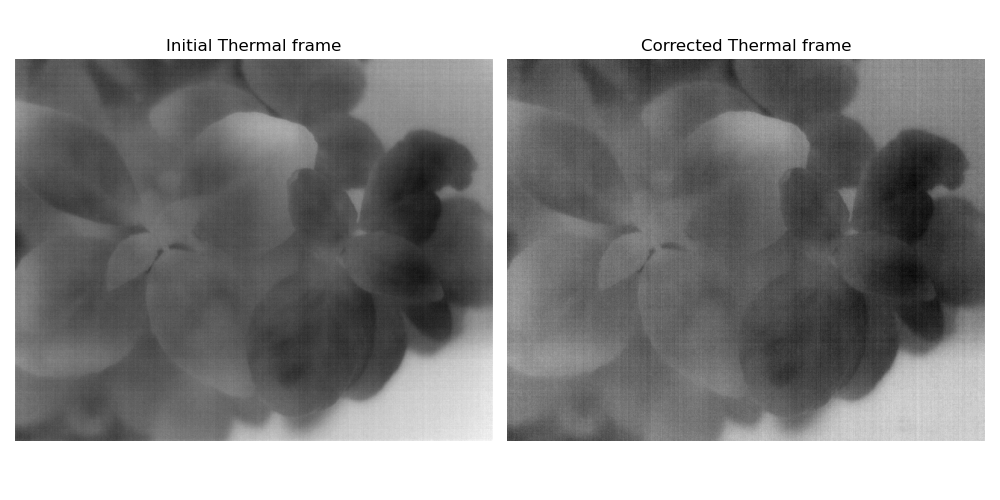

In [11]:
thr_cam_obj.camera.do_ffc()

num_init = 100
init_frame = np.zeros((512, 640), dtype=np.float32)
for _ in range(num_init):
    frame_init, frame_timestamp = thr_cam_obj.get_next_image()
    frame_init = frame_init[:, ::-1]
    init_frame += frame_init
init_frame /= num_init

img1 = init_frame
img2 = init_frame + correction_term

min_val = np.min([np.min(img1), np.min(img2)])
max_val = np.max([np.max(img1), np.max(img2)])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(init_frame, cmap='gray', vmin=min_val, vmax=max_val)
# ax.imshow(preview_thermal_frame(init_frame, apply_colormap=False), cmap='gray')
ax[0].set_title('Initial Thermal frame')
ax[0].axis('off')
ax[1].imshow(init_frame + correction_term, cmap='gray', vmin=min_val, vmax=max_val)
ax[1].set_title('Corrected Thermal frame')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [12]:
curr_stage_pos = STAGE_POS_LP700
stage.move_absolute_raw(curr_stage_pos)

pixel_val1 = []
pixel_val2 = []
tstamp = []
py1, px1 = 310, 360
py2, px2 = 210, 310

vis_img, vis_tstamp = vis_cam_obj.get_next_image()
thr_img, thr_tstamp = thr_cam_obj.get_next_image()
thr_img = thr_img[:, ::-1].astype(np.float32)

running = True

def vis_cam_thread():
    global vis_cam_obj
    global vis_img, vis_tstamp, running

    while running:
        vis_img, vis_tstamp = vis_cam_obj.get_next_image()

def thr_cam_thread():
    global thr_cam_obj
    global thr_img, thr_tstamp, running, pixel_val1, pixel_val2, tstamp

    while running:
        thr_img_, thr_tstamp = thr_cam_obj.get_next_image()
        thr_img = thr_img_[:, ::-1].astype(np.float32)

        pixel_val1.append(thr_img[py1, px1])
        pixel_val2.append(thr_img[py2, px2])
        tstamp.append(thr_tstamp)
        

# moving_average_frame = None
# diff_threshold = 10
# num_stabilized_frames = 10
# frame_diffs = []

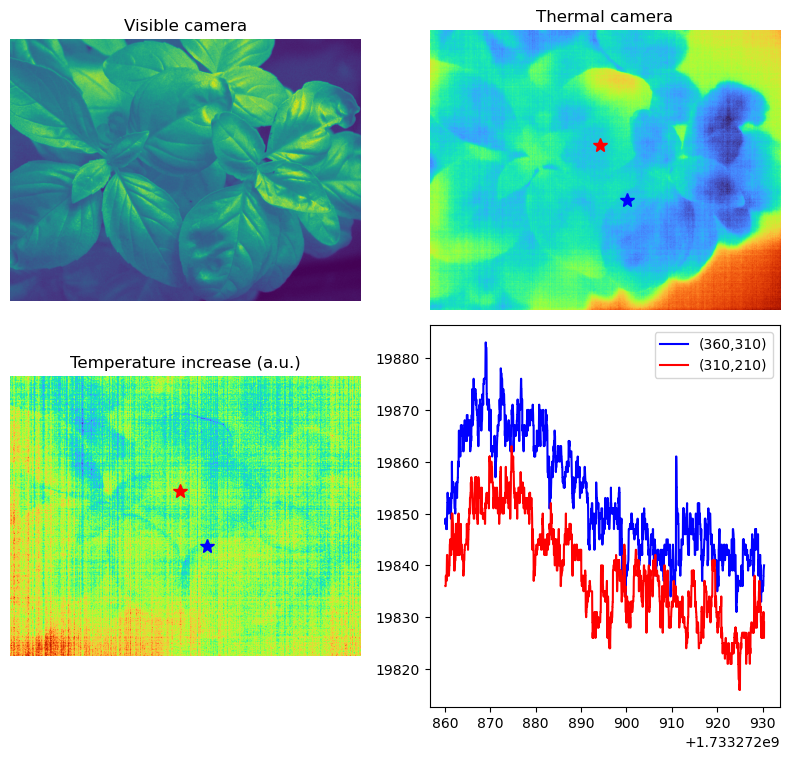

: 

In [13]:
vis_thread = threading.Thread(target=vis_cam_thread)
thr_thread = threading.Thread(target=thr_cam_thread)

vis_thread.start()
thr_thread.start()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

start_time = time.time()
while True:
    tic = time.time()

    thr_img_viz = thr_img #- init_frame
    diff_img_viz = thr_img - init_frame

    min_val, max_val = np.percentile(thr_img_viz, [0.01, 99.99])
    thr_img_viz = rescale_intensity(thr_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    thr_img_viz = thr_img_viz.astype(np.uint8)

    min_val, max_val = np.percentile(diff_img_viz, [0.01, 99.99])
    diff_img_viz = rescale_intensity(diff_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    diff_img_viz = diff_img_viz.astype(np.uint8)


    axes[0, 0].clear()
    axes[0, 0].imshow(vis_img)
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Visible camera')

    axes[0, 1].clear()
    axes[0, 1].imshow(thr_img, cmap='turbo')
    axes[0, 1].plot(px1, py1, 'b*', markersize=10)
    axes[0, 1].plot(px2, py2, 'r*', markersize=10)
    axes[0, 1].set_title('Thermal camera')
    axes[0, 1].axis('off')
    axes[1, 0].clear()
    axes[1, 0].imshow(diff_img_viz, cmap='turbo')
    axes[1, 0].set_title('Temperature increase (a.u.)')
    axes[1, 0].plot(px1, py1, 'b*', markersize=10)
    axes[1, 0].plot(px2, py2, 'r*', markersize=10)
    axes[1, 0].axis('off')
    axes[1, 1].clear()
    axes[1, 1].plot(tstamp, pixel_val1, label="({},{})".format(px1, py1), color='b')
    axes[1, 1].plot(tstamp, pixel_val2, label="({},{})".format(px2, py2), color='r')
    axes[1, 1].legend()
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())


In [14]:
running = False
vis_thread.join()
thr_thread.join()

## Data Collection Routine

In [13]:
# pulsetrain_settings = {
#         'num_pulses' : 7,
#         'light_control_voltages': [0.6, 1.2, 1.8, 2.5, 5.0, 7.5, 10],                 # in volts
#         'light_intensity_perc'  : [2.47, 5.50, 9.94, 15.97, 37.35, 69.37, 100],       # roughly converted from voltage to intensity percentage
#         'light_pulse_duration'  : [20, 20, 20, 20, 20, 20, 20],               # in s
#         'relaxation_duration'   : [180, 180, 180, 180, 180, 180, 180],                # in s
#         'fps_during_pulse' : 10,
#         'fps_between_pulses' : 1,
#         'vis_cam_exposure_sp700' : [1000, 750, 500, 250, 50, 20, 10],
#         'vis_cam_exposure_lp700' : [15000, 15000, 10000, 5000, 2000, 1000, 750]
# }

# # pulsetrain_settings['pulse_energy'] = 200
# # pulsetrain_settings['light_pulse_duration'] = [np.round(pulsetrain_settings['pulse_energy'] / i, 0) for i in pulsetrain_settings['light_intensity_perc']]     # in s
# # pulsetrain_settings['relaxation_duration'] = [120 for _ in pulsetrain_settings['light_intensity_perc']]                                # in s

In [14]:
pulsetrain_settings = {
        'num_pulses' : 7,
        'light_control_voltages': [1.81, 2.99, 4.21, 5.22, 6.76, 8.35, 10],                 # in volts
        'light_intensity_perc'  : [10, 20, 30, 40, 60, 80, 100],       # roughly converted from voltage to intensity percentage
        'light_pulse_duration'  : [10, 10, 10, 10, 10, 10, 10],               # in s
        'relaxation_duration'   : [80, 80, 80, 80, 80, 80, 80],                # in s
        # 'extra_light_control_voltages' : [0.61, 1.15, 1.5],
        # 'extra_light_intensity_perc' : [2.5, 5.0, 7.5],
        # 'extra_light_pulse_duration' : [20, 20, 20],
        # 'extra_pulse_relaxation_duration' : [40, 40, 40],
        'fps_during_pulse' : 10,
        'fps_between_pulses' : 1,
        'vis_cam_exposure_sp700' : [500, 500, 250, 250, 50, 20, 10],
        'vis_cam_exposure_lp700' : [10000, 10000, 5000, 5000, 2000, 1000, 750]
}

# pulsetrain_settings['pulse_energy'] = 200
# pulsetrain_settings['light_pulse_duration'] = [np.round(pulsetrain_settings['pulse_energy'] / i, 0) for i in pulsetrain_settings['light_intensity_perc']]     # in s
# pulsetrain_settings['relaxation_duration'] = [120 for _ in pulsetrain_settings['light_intensity_perc']]                                # in s

In [15]:
# pulsetrain_settings = {
#         'num_pulses' : 3,
#         'light_control_voltages': [0.6, 1.8, 2.5],                 # in volts
#         'light_intensity_perc'  : [2.47, 9.94, 15.97],       # roughly converted from voltage to intensity percentage
#         'light_pulse_duration' : [30, 20, 15],
#         'relaxation_duration' : [60, 60, 60],
#         'fps_during_pulse' : 50,
#         'fps_between_pulses' : 3,
#         'vis_cam_exposure_sp700' : [300, 200, 100],
#         'vis_cam_exposure_lp700' : [10000, 10000, 5000]
# }

# # pulsetrain_settings['pulse_energy'] = 200
# # pulsetrain_settings['light_pulse_duration'] = [np.round(pulsetrain_settings['pulse_energy'] / i, 0) for i in pulsetrain_settings['light_intensity_perc']]     # in s
# # pulsetrain_settings['relaxation_duration'] = [120 for _ in pulsetrain_settings['light_intensity_perc']]                                # in s

In [16]:
# def collect_sp700_image(exposure):
#     global ls_vis_frames
#     global ls_vis_tstamps
#     global ls_vis_exposures
#     global ls_vis_filter_pos

#     # Set filter position to SP700
#     curr_stage_pos = STAGE_POS_SP700
#     stage.move_absolute_raw(curr_stage_pos, True)

#     # Set the exposure for the visible camera
#     curr_exp = vis_cam_obj.get_exposure()
#     vis_cam_obj.set_exposure(exposure)

#     vis_img, vis_tstamp = vis_cam_obj.get_next_image(), time.time()

#     ls_vis_frames.append(vis_img)
#     ls_vis_tstamps.append(vis_tstamp)
#     ls_vis_exposures.append(vis_cam_obj.get_exposure())
#     ls_vis_filter_pos.append(curr_stage_pos)

#     # Set filter position to LP700
#     curr_stage_pos = STAGE_POS_LP700
#     stage.move_absolute_raw(curr_stage_pos, True)

#     # Reset the exposure for the visible camera
#     vis_cam_obj.set_exposure(curr_exp)

In [17]:
running = True
pause_recording = False

save_fps = pulsetrain_settings['fps_between_pulses']
light_obj.set_voltage(0.0)
curr_stage_pos = STAGE_POS_LP700
stage.move_absolute_raw(curr_stage_pos, True)
vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][0])


## Set up capture thread for visible camera
ls_vis_frames = []
ls_vis_tstamps = []
ls_vis_exposures = []
ls_vis_gains = []

def visible_capture_thread():
    global ls_vis_frames
    global ls_vis_tstamps
    global ls_vis_exposures
    global ls_vis_gains
    global running
    global pause_recording
    global save_fps
    last_frame_time = time.time()

    while running:
        if pause_recording:
            continue
        vis_img, vis_tstamp, vis_exp, vis_gain = vis_cam_obj.get_next_image(metadata=True)
        if vis_tstamp - last_frame_time > 1 / save_fps:
            ls_vis_frames.append(vis_img)
            ls_vis_tstamps.append(vis_tstamp)
            ls_vis_exposures.append(vis_exp)
            ls_vis_gains.append(vis_gain)
            last_frame_time = vis_tstamp

vis_cap_thread = threading.Thread(target=visible_capture_thread)

# Set up capture thread for thermal camera
ls_thr_frames = []
ls_thr_tstamps = []

def thermal_capture_thread():
    global ls_thr_frames
    global ls_thr_tstamps
    global running
    global pause_recording
    global save_fps
    _, last_frame_time = thr_cam_obj.get_next_image()

    while running:
        if pause_recording:
            continue
        thr_img, thr_tstamp = thr_cam_obj.get_next_image()
        if thr_tstamp - last_frame_time > 1 / save_fps:
            ls_thr_frames.append(thr_img)
            ls_thr_tstamps.append(thr_tstamp)
            last_frame_time = thr_tstamp

thr_cap_thread = threading.Thread(target=thermal_capture_thread)

# Set FFC to manual for the thermal camera
thr_cam_obj.camera.set_ffc_manual()
# Do FFC for the thermal camera
thr_cam_obj.camera.do_ffc()
time.sleep(1)

# Start the threads
vis_cap_thread.start()
thr_cap_thread.start()

# Light pulse routine
num_pulses = pulsetrain_settings['num_pulses']
# Initial relaxation period
time.sleep(10)
for i in range(num_pulses):
    print(f"Pulse {i+1} of {num_pulses}")
# for i in range(num_pulses-1, -1, -1):
#     print(f"Pulse {i+1} of {num_pulses}")

    # pause_recording = True
    # time.sleep(0.5)

    # collect_sp700_image(pulsetrain_settings['vis_cam_exposure_sp700'][0])

    # Set the exposure for the visible camera
    vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][i], check=False)

    # Change the save fps
    save_fps = pulsetrain_settings['fps_during_pulse']

    # pause_recording = False
    # time.sleep(0.5)

    time.sleep(1)
    # Set the light intensity
    print(f"Setting light intensity to {pulsetrain_settings['light_intensity_perc'][i]}%")
    light_obj.set_voltage(pulsetrain_settings['light_control_voltages'][i])
    # Record the light pulse
    time.sleep(pulsetrain_settings['light_pulse_duration'][i])

    # pause_recording = True
    # time.sleep(0.5)

    # collect_sp700_image(pulsetrain_settings['vis_cam_exposure_sp700'][i])



    # pause_recording = False
    # time.sleep(0.5)

    # time.sleep(1)
    # Turn off the light
    print("Turning off the light")
    light_obj.set_voltage(0.0)
    time.sleep(1)

    # Set the exposure for the visible camera
    vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][0], check=False)

    # Change the save fps
    save_fps = pulsetrain_settings['fps_between_pulses']

    # Record the relaxation period
    time.sleep(pulsetrain_settings['relaxation_duration'][i])

# Set FFC to Auto
thr_cam_obj.camera.set_ffc_auto()
thr_cam_obj.camera.do_ffc()

print("Stopping the threads")
running = False
vis_cap_thread.join()
thr_cap_thread.join()

# Collect visible images for SP700 for all the pulses
vis_frames_sp700 = []
vis_tstamps_sp700 = []
vis_exposures_sp700 = []
vis_gains_sp700 = []

vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_sp700'][0])
curr_stage_pos = STAGE_POS_SP700
stage.move_absolute_raw(curr_stage_pos, True)

vis_frame, vis_tstamp, vis_exp, vis_gain = vis_cam_obj.get_next_image(metadata=True)
vis_frames_sp700.append(vis_frame)
vis_tstamps_sp700.append(vis_tstamp)
vis_exposures_sp700.append(vis_exp)
vis_gains_sp700.append(vis_gain)

for i in range(num_pulses):
    light_obj.set_voltage(pulsetrain_settings['light_control_voltages'][i])
    time.sleep(1)

    vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_sp700'][i])
    
    vis_frame, vis_tstamp, vis_exp, vis_gain = vis_cam_obj.get_next_image(metadata=True)
    vis_frames_sp700.append(vis_frame)
    vis_tstamps_sp700.append(vis_tstamp)
    vis_exposures_sp700.append(vis_exp)
    vis_gains_sp700.append(vis_gain)

light_obj.set_voltage(0.0)
vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][0])

curr_stage_pos = STAGE_POS_LP700
stage.move_absolute_raw(curr_stage_pos, True)

print("Saving the data")
ls_vis_frames = np.array(ls_vis_frames)
ls_vis_tstamps = np.array(ls_vis_tstamps)
ls_vis_exposures = np.array(ls_vis_exposures)
ls_vis_gains = np.array(ls_vis_gains)

ls_thr_frames = np.array(ls_thr_frames)
ls_thr_tstamps = np.array(ls_thr_tstamps)

vis_frames_sp700 = np.array(vis_frames_sp700)
vis_tstamps_sp700 = np.array(vis_tstamps_sp700)
vis_exposures_sp700 = np.array(vis_exposures_sp700)
vis_gains_sp700 = np.array(vis_gains_sp700)

output_filename = '../data/pulse_train_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
np.savez(output_filename, ls_vis_frames=ls_vis_frames,
                          ls_vis_tstamps=ls_vis_tstamps,
                          ls_vis_exposures=ls_vis_exposures,
                          ls_vis_gains=ls_vis_gains,
                          ls_thr_frames=ls_thr_frames,
                          ls_thr_tstamps=ls_thr_tstamps,
                          vis_frames_sp700=vis_frames_sp700,
                          vis_tstamps_sp700=vis_tstamps_sp700,
                          vis_exposures_sp700=vis_exposures_sp700,
                          vis_gains_sp700=vis_gains_sp700,
                          **pulsetrain_settings)

Exposure set to 10002.000000 us...
Pulse 1 of 7
Exposure set to 10002.000000 us...
Setting light intensity to 10%
Turning off the light
Exposure set to 10002.000000 us...
Pulse 2 of 7
Exposure set to 10002.000000 us...
Setting light intensity to 20%
Turning off the light
Exposure set to 10002.000000 us...
Pulse 3 of 7
Exposure set to 4999.000000 us...
Setting light intensity to 30%
Turning off the light
Exposure set to 10002.000000 us...
Pulse 4 of 7
Exposure set to 4999.000000 us...
Setting light intensity to 40%
Turning off the light
Exposure set to 10002.000000 us...
Pulse 5 of 7
Exposure set to 1999.000000 us...
Setting light intensity to 60%
Turning off the light
Exposure set to 10002.000000 us...
Pulse 6 of 7
Exposure set to 1000.000000 us...
Setting light intensity to 80%
Turning off the light
Exposure set to 10002.000000 us...
Pulse 7 of 7
Exposure set to 748.000000 us...
Setting light intensity to 100%
Turning off the light
Exposure set to 10002.000000 us...
Stopping the threa

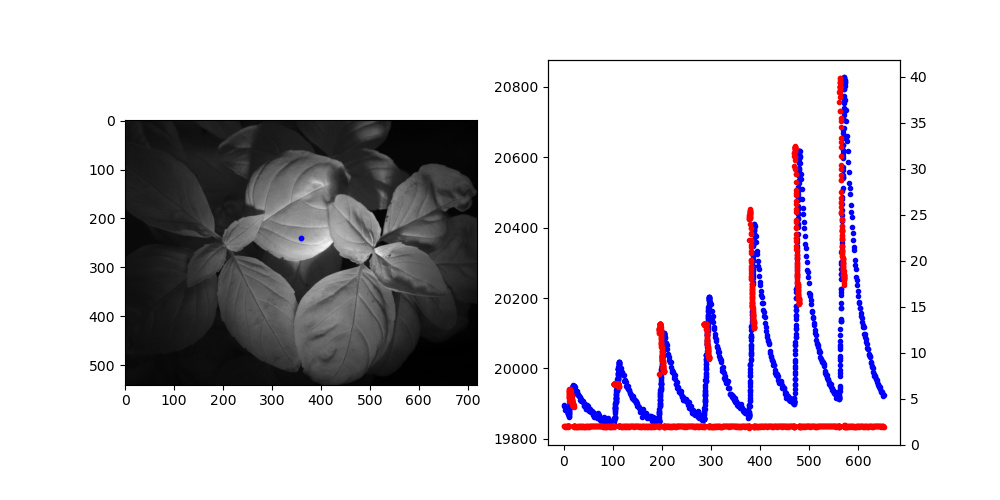

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
px1, py1 = 360, 240

# ax[0].imshow(vis_frames_sp700[-1, :, :], cmap='gray')
# ax[0].imshow(ls_vis_frames[-1, :, :], cmap='gray')
ax[0].imshow(ls_vis_frames[-100, :, :], cmap='gray')
# ax[0].imshow(ls_thr_frames[-1, :, :], cmap='turbo')
ax[0].scatter(px1, py1, c='b', s=10)
ax[1].plot(ls_thr_tstamps - ls_vis_tstamps[0], ls_thr_frames[:, py1, px1], 'b.')
ax2 = ax[1].twinx()
vis_pixel_val = []
vis_pixel_tstamp = []
for i in range(ls_vis_frames.shape[0]):
    vis_pixel_val.append(ls_vis_frames[i, py1, px1] / ls_vis_exposures[i])
    vis_pixel_tstamp.append(ls_vis_tstamps[i] - ls_vis_tstamps[0])
ax2.plot(vis_pixel_tstamp, vis_pixel_val, 'r.')
plt.show()

In [ ]:
from ipywidgets import interact, IntSlider

plt.figure(figsize=(10, 5))

def show_frame(frame_number):
    plt.imshow(ls_vis_frames[frame_number, :, :], cmap='gray')
    plt.title(f'Frame {frame_number}, time: {ls_vis_tstamps[frame_number] - ls_vis_tstamps[0]:.2f}, filter pos: {ls_vis_filter_pos[frame_number]}, min: {ls_vis_frames[frame_number].min()}, max: {ls_vis_frames[frame_number].max()}')
    plt.show()

interact(show_frame, frame_number=IntSlider(min=0, max=len(ls_vis_frames)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_number', max=8280), Output()), _dom_classes=('widg…

<function __main__.show_frame(frame_number)>